In [18]:
import pandas as pd
from pprint import pprint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pyLDAvis
import pyLDAvis.gensim
stop=stopwords.words('english')
import spacy
import numpy as np
import re
from matplotlib import pyplot as plt
nlp=spacy.load('en_core_web_sm')


Load and preprocess the data

In [2]:
data=pd.read_excel('/Volumes/T7/UIUC/Summer_2023/IMLS/STEM programming coding - Goals Activities Outcomes - SHARE.xlsx')#, encoding='latin-1')

In [3]:
data.columns

Index(['New number', 'Project code', 'Project goals',
       'Project activities/outcomes',
       'Grant start year (when was this grant awarded)'],
      dtype='object')

In [4]:
data=data.fillna('') # fill empty cells with empty string
data['goal']=data['Project goals']+data['Project activities/outcomes']
data['goal']=data['goal'].str.lower()

In [5]:
def lemmatization(dataframe):
    dataframe['goal_lower'] = dataframe['goal'].astype(str).str.lower()
    dataframe['stopword'] = dataframe['goal_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    dataframe['punct'] = dataframe['stopword'].str.replace('[^\w\s]', '')
    dataframe['lemma'] = dataframe['punct'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['lemma_length'] = dataframe['lemma'].apply(lambda x: ' '.join([s for s in x.split() if s is not None and len(s) >= 3 and not re.match(r'^\d+$', s)]))
    dataframe['lemma_stop'] = dataframe['lemma_length'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    dataframe['final'] = dataframe['lemma_stop'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['token'] = dataframe['final'].apply(word_tokenize)
    return dataframe

<>:4: DeprecationWarning: invalid escape sequence '\w'
<>:4: DeprecationWarning: invalid escape sequence '\w'
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_1696/4137522434.py:4: DeprecationWarning: invalid escape sequence '\w'
  dataframe['punct'] = dataframe['stopword'].str.replace('[^\w\s]', '')


In [6]:
data=lemmatization(data)

In [20]:
data

,New number,Project code,Project goals,Project activities/outcomes,Grant start year (when was this grant awarded),goal,goal_lower,stopword,punct,lemma,lemma_length,lemma_stop,final,token,dominant_topic
0,1,ARPML-250840-OMLS-22,The museum will design the project to increas...,"The Museum of Science, Boston will offer a fre...",2022,the museum will design the project to increas...,the museum will design the project to increas...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,"[museum, design, project, increase, accessibil...",9
1,2,ARPML-250903-OMLS-22,"Homewood Science Center, located outside Chica...","The new kits will include teacher guides, inst...",2022,"homewood science center, located outside chica...","homewood science center, located outside chica...","homewood science center, located outside chica...","homewood science center, located outside chica...","homewood science center , locate outside chica...",homewood science center locate outside chicago...,homewood science center locate outside chicago...,homewood science center locate outside chicago...,"[homewood, science, center, locate, outside, c...",1
2,3,ARPML-250790-OMLS-22,Clay County Public Library System in Florida w...,"With dedicated personnel, these formerly self-...",2022,clay county public library system in florida w...,clay county public library system in florida w...,clay county public library system florida reim...,clay county public library system florida reim...,clay county public library system florida reim...,clay county public library system florida reim...,clay county public library system florida reim...,clay county public library system florida reim...,"[clay, county, public, library, system, florid...",5
3,4,ARPML-250600-OMLS-22,"Sciencenter in Ithaca, New York, will conduct ...",they plan to upgrade the museum's Wi-Fi connec...,2022,"sciencenter in ithaca, new york, will conduct ...","sciencenter in ithaca, new york, will conduct ...","sciencenter ithaca, new york, conduct capacity...","sciencenter ithaca, new york, conduct capacity...","sciencenter ithaca , new york , conduct capaci...",sciencenter ithaca new york conduct capacity b...,sciencenter ithaca new york conduct capacity b...,sciencenter ithaca new york conduct capacity b...,"[sciencenter, ithaca, new, york, conduct, capa...",9
4,5,ARPML-250537-OMLS-22,Orlando Science Center in Florida will partner...,The museum will recruit at least 120 classroom...,2022,orlando science center in florida will partner...,orlando science center in florida will partner...,orlando science center florida partner orange ...,orlando science center florida partner orange ...,orlando science center florida partner orange ...,orlando science center florida partner orange ...,orlando science center florida partner orange ...,orlando science center florida partner orange ...,"[orlando, science, center, florida, partner, o...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,LG-47-12-0385-12,"The New York Hall of Science in Queens, New Yo...",Digital Making is a program that will empower ...,2012,"the new york hall of science in queens, new yo...","the new york hall of science in queens, new yo...","new york hall science queens, new york, plan p...","new york hall science queens, new york, plan p...","new york hall science queen , new york , plan ...",new york hall science queen new york plan prot...,new york hall science queen new york plan prot...,new york hall science queen new york plan prot...,"[new, york, hall, science, queen, new, york, p...",9
124,125,LG-66-12-0634-12,Creating a Collaboration for Ongoing Visitor E...,"The two-day forum will bring together experts,...",2012,creating a collaboration for ongoing visitor e...,creating 

NMF

In [7]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['final'])


In [8]:
num_topics = 10  # Replace with the desired number of topics
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)

NMF(n_components=10, random_state=42)

In [10]:
num_top_words = 10  # Replace with the desired number of top words
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    print()


Topic #1:
learn, stem, library, professional, librarian, resource, equity, summer, practice, school

Topic #2:
student, school, center, stem, program, activity, provide, learn, pandemic, 19

Topic #3:
information, datum, university, science, school, project, study, department, graduate, curriculum

Topic #4:
citizen, scientist, science, arizona, library, garden, project, state, scistarter, scale

Topic #5:
tribal, book, tribe, shawnee, nation, native, library, oklahoma, eastern, ebook

Topic #6:
teen, space, medium, design, lab, challenge, digital, plan, project, use

Topic #7:
library, county, public, skill, service, provide, workforce, initiative, development, community

Topic #8:
nakoda, aaniiih, outreach, college, history, fort, belknap, culture, language, indian

Topic #9:
expert, stem, family, child, museum, area, science, hand, education, story

Topic #10:
museum, digital, community, program, content, event, pandemic, member, new, programming



Q. What is the dominant topic for each document?

In [16]:
dominant_topics = np.argmax(nmf.transform(tfidf_matrix), axis=1)
data['dominant_topic'] = dominant_topics

Q. What is the topic distribution for each document?

In [37]:
topic_dist_list=[]
for i, doc_topics in enumerate(document_topics):
    topic_dist={}
    for topic, prob in doc_topics:
        topic_dist[topic]=prob
    topic_dist_list.append(topic_dist)
data['topic_dist']=topic_dist_list

Q. What is the topic distribution for each document?

In [24]:
topic_distribution=nmf.transform(tfidf_matrix)
topic_dict = {}

for topic_idx in range(num_topics):
    topic_dict[topic_idx+1] = topic_distribution[:, topic_idx]

In [26]:
topic_dict

{1: array([0.        , 0.        , 0.        , 0.00047478, 0.00429189,
        0.        , 0.05033661, 0.        , 0.        , 0.        ,
        0.01660673, 0.02073861, 0.        , 0.        , 0.09283068,
        0.        , 0.        , 0.00512333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00967935,
        0.        , 0.06455343, 0.03378391, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.25383129,
        0.        , 0.14004408, 0.09476721, 0.        , 0.00970482,
        0.03891327, 0.        , 0.05990279, 0.        , 0.04647092,
        0.00173225, 0.09313129, 0.04764745, 0.26812909, 0.        ,
        0.        , 0.03448385, 0.        , 0.18336664, 0.01362254,
        0.        , 0.0286063 , 0.03780743, 0.00402234, 0.00664563,
        0.        , 0.05070456, 0.00766541, 0.        , 0.        ,
        0.00888794, 0.        , 0.        , 0.12935523, 0.01642026,
        0.        , 0.        , 0.05466259, 0

In [21]:
data.head(2)

,New number,Project code,Project goals,Project activities/outcomes,Grant start year (when was this grant awarded),goal,goal_lower,stopword,punct,lemma,lemma_length,lemma_stop,final,token,dominant_topic
0,1,ARPML-250840-OMLS-22,The museum will design the project to increas...,"The Museum of Science, Boston will offer a fre...",2022,the museum will design the project to increas...,the museum will design the project to increas...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,museum design project increase accessibility f...,"[museum, design, project, increase, accessibil...",9
1,2,ARPML-250903-OMLS-22,"Homewood Science Center, located outside Chica...","The new kits will include teacher guides, inst...",2022,"homewood science center, located outside chica...","homewood science center, located outside chica...","homewood science center, located outside chica...","homewood science center, located outside chica...","homewood science center , locate outside chica...",homewood science center locate outside chicago...,homewood science center locate outside chicago...,homewood science center locate outside chicago...,"[homewood, science, center, locate, outside, c...",1


Visualize topic distribution

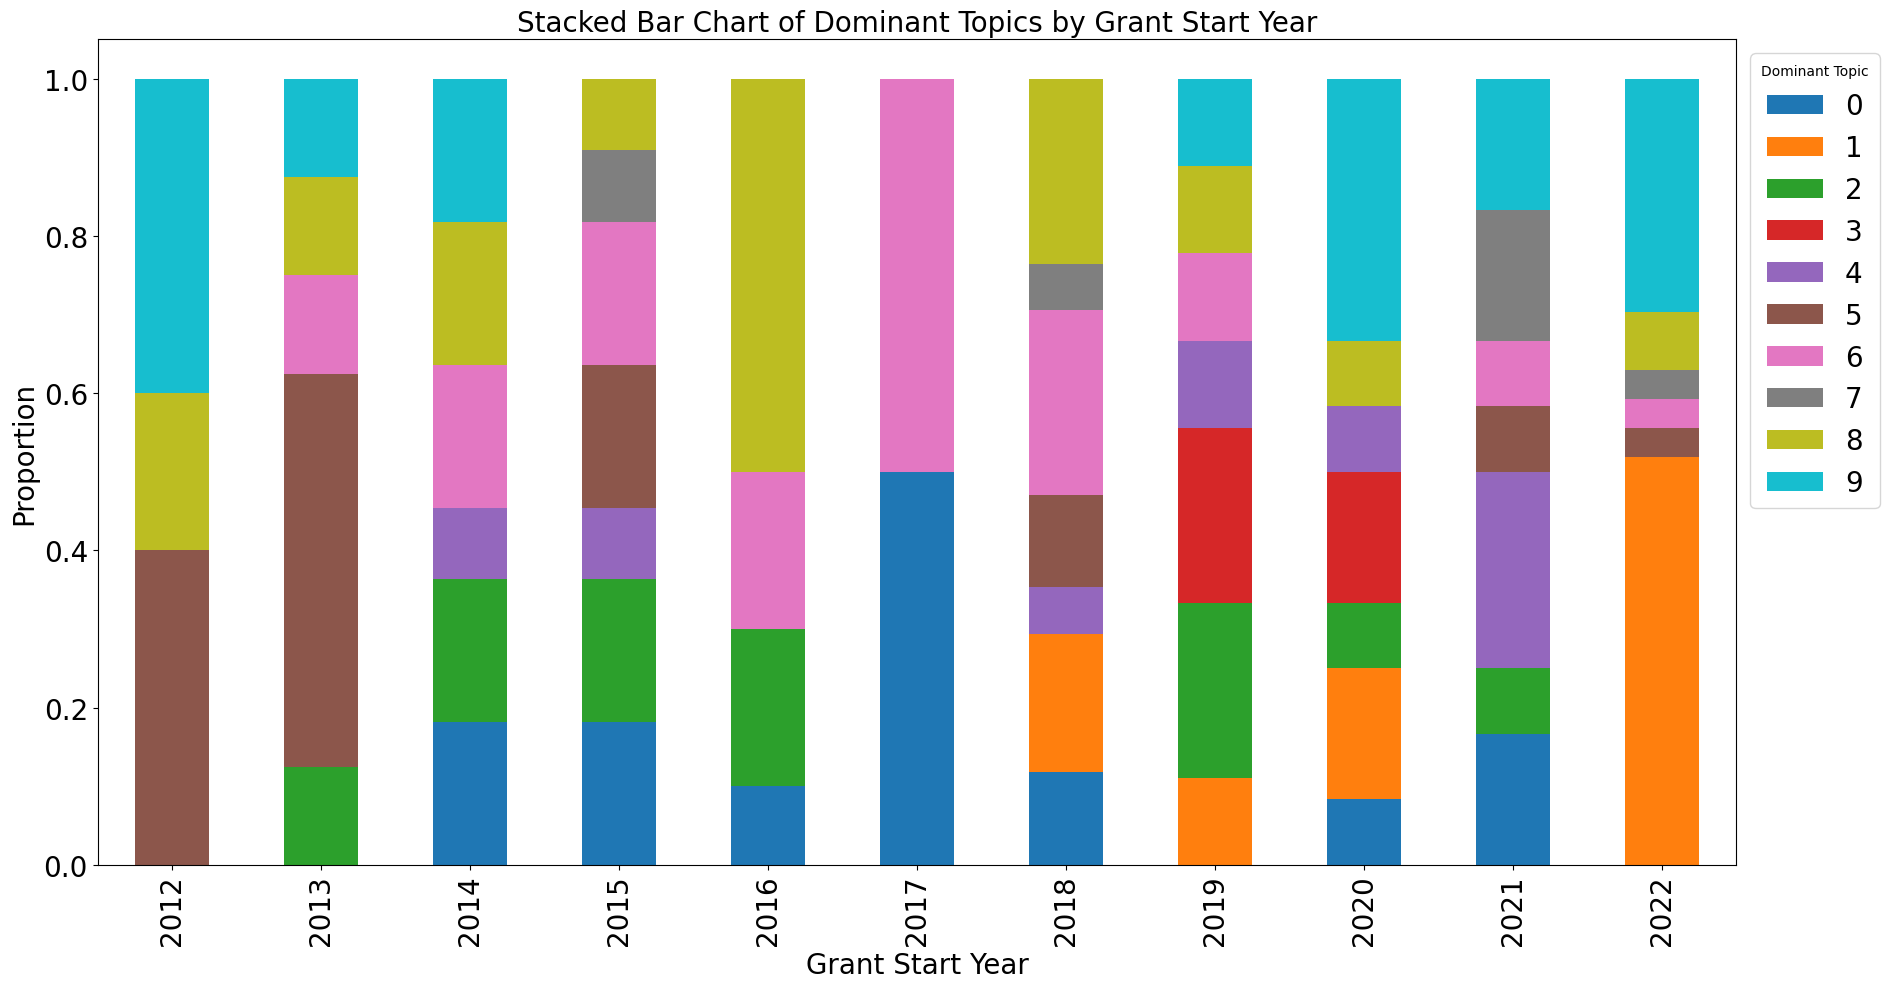

In [19]:
grouped_data = data.groupby(['Grant start year (when was this grant awarded)', 'dominant_topic']).size()
reshaped_data = grouped_data.unstack(level='dominant_topic')
normalized_data = reshaped_data.div(reshaped_data.sum(axis=1), axis=0)

ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 10), fontsize=20)

plt.xlabel('Grant Start Year', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

legend = ax.legend(title='Dominant Topic', bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

plt.title('Stacked Bar Chart of Dominant Topics by Grant Start Year', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()